In [1]:
############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################


In [1]:
%matplotlib inline
import glob
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

import dask_cudf
import copy
import cupy as cp
import cudf
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

sns.set()
data_path = './1m_cleaned/'

In [2]:
use_dask=True
client=None
if use_dask:
    import subprocess

    from dask.distributed import Client, wait, progress
    from dask_cuda import LocalCUDACluster

    import dask.dataframe as dd

    cmd = "hostname --all-ip-addresses"
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    IPADDR = str(output.decode()).split()[0]

    cluster = LocalCUDACluster(ip=IPADDR)
    client = Client(cluster)
client

Client Scheduler: tcp://192.168.1.171:33187 Dashboard: http://192.168.1.171:8787/status,Cluster Workers: 1 Cores: 1 Memory: 62.81 GiB


## Part 1 - Add any features and save

In [3]:
# we use .persist() so we do not re-.compute() the data each time.
fixed_txns_paths = sorted(glob.glob(f'{data_path}/fixed*.csv'))

# if use_dask:
#     txns = dask_cudf.concat([dask_cudf.read_csv(fpath, dtype=['int', 'int', 'int', 'int', 
#                                                               'float32', 'float32', 'float32', 'int',
#                                                               'int', 'int', 'int', 'float32', 'float32']) 
#                              for fpath in fixed_txns_paths]).reset_index()#.persist()
# else:
#     or without dask_cudf
#     fixed_txns_paths = fixed_txns_paths[:2]  # choose subset of files to fit in single GPU memory

txns = cudf.concat([cudf.read_csv(fpath) for fpath in fixed_txns_paths], axis=0).reset_index()

# feel free to use these if desired.
# accounts = dask_cudf.read_csv(f'{data_path}/accounts.csv')
# alerts = dask_cudf.read_csv(f'{data_path}/alerts.csv')
txns

,index,tx_id,timestamp,sender_account_id,receiver_account_id,tx_amount,sender_init_balance,receiver_init_balance,alert_id,sender_is_fraud,receiver_is_fraud,is_fraud,sender_fin_balance,receiver_fin_balance
0,0,1.0,0.0,703302.0,161218.0,31.01,186.06,149.29,-1.0,0.0,0.0,0.0,155.05,180.30
1,1,2.0,0.0,703302.0,336794.0,31.01,155.05,395.43,-1.0,0.0,0.0,0.0,124.04,426.44
2,2,3.0,0.0,703302.0,24362.0,31.01,124.04,293.91,-1.0,0.0,1.0,0.0,93.03,324.92
3,3,4.0,0.0,703302.0,980979.0,31.01,93.03,277.33,-1.0,0.0,0.0,0.0,62.02,308.34
4,4,5.0,0.0,703302.0,485951.0,31.01,62.02,391.16,-1.0,0.0,0.0,0.0,31.01,422.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124703179,41567723,124703180.0,199.0,512072.0,528208.0,39.00,1565.64,1091525.22,-1.0,0.0,0.0,0.0,1526.64,1091564.22
124703180,41567724,124703181.0,199.0,512072.0,571714.0,39.00,1526.64,1437141.40,-1.0,0.0,0.0,0.0,1487.64,1437180.40
124703181,41567725,124703182.0,199.0,512072.0,122486.0,39.00,1487.64,-14520758.61,-1.0,0.0,0.0,0.0,1448.64,-14520719.61
124703182,41567726,124703183.0,199.0,512072.0,946991.0,39.00,1448.64,15186703.89,-1.0,0.0,1.0,0.0,1409.64,15186742.89


Add time since last transaction feature
- use diff of transactions
- first transaction is imputed with mean time between transaction of the transactions that follow afterwards.

In [4]:
shft = txns[['timestamp', 'sender_account_id']].groupby('sender_account_id')

# Define a function to apply to each group
from numba import cuda

def time_since_last_txn(timestamp, time_since_last_txn):
    total = 0
    ctr=0
    for i in range(cuda.threadIdx.x, len(timestamp), cuda.blockDim.x):
        if i==0:
            time_since_last_txn[i] = 0
        else:
            time_since_last_txn[i] = timestamp[i]- timestamp[i-1]
        total += time_since_last_txn[i]
        ctr+=1
        
    time_since_last_txn[0] = total/(ctr-1)

result = shft.apply_grouped(time_since_last_txn,
                              incols=['timestamp'],
                              outcols={'time_since_last_txn': np.float64},
                              # threads per block
                              tpb=1)

txns['time_since_last_txn'] = result['time_since_last_txn']
result

,timestamp,sender_account_id,time_since_last_txn
275900,0.0,0.0,9.5625
8387481,13.0,0.0,13.0000
25221257,40.0,0.0,27.0000
25967600,41.0,0.0,1.0000
32251308,51.0,0.0,10.0000
...,...,...,...
108258932,173.0,999999.0,0.0000
108258933,173.0,999999.0,0.0000
108258934,173.0,999999.0,0.0000
108258935,173.0,999999.0,0.0000


In [5]:
txns.sender_account_id.nunique()

1000000

We just went through 1 Million sender accounts and computed the time diffs per transaction for ~125M rows!

You might consider scaling some of the features with `cuml`, example commented out below. Note fit only on train data, which may require splitting the data via `train_test_split` before we save the data.

In [13]:
#
# from cuml.experimental.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train[['tx_amount', 'sender_init_balance', 'receiver_init_balance',
#                               'sender_fin_balance', 'receiver_fin_balance']] =\
# scaler.fit_transform(X_train[['tx_amount', 'sender_init_balance', 'receiver_init_balance',
#                               'sender_fin_balance', 'receiver_fin_balance']])

# X_test[['tx_amount', 'sender_init_balance', 'receiver_init_balance',
#                               'sender_fin_balance', 'receiver_fin_balance']] =\
# scaler.transform(X_test[['tx_amount', 'sender_init_balance', 'receiver_init_balance',
#                               'sender_fin_balance', 'receiver_fin_balance']])

In [7]:
txns.to_parquet(f'{data_path}/txns.pq')

## Part 2 - Restart Kernel, load libraries and continue from here

In [3]:
txns = dask_cudf.read_parquet(f'{data_path}/txns.pq')

## XGB

In [4]:
import xgboost as xgb
import numpy as np
from collections import OrderedDict
import gc
from glob import glob
import os
import pandas as pd
from copy import copy
from time import time
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, \
                            roc_curve, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from timeit import default_timer
import matplotlib.pyplot as plt
import pickle
import shap

In [5]:
# 'tx_id', 
# train_cols = ['timestamp', 'sender_account_id' ,'receiver_account_id', 'tx_amount', 
#               'sender_init_balance', 'receiver_init_balance', 'sender_fin_balance', 'receiver_fin_balance']
train_cols = ['time_since_last_txn', 'tx_amount', 'sender_account_id','receiver_account_id',
              'sender_init_balance', 'receiver_init_balance', 'sender_fin_balance', 'receiver_fin_balance']
target_col = ['is_fraud']

In [6]:
txns[train_cols]

,time_since_last_txn,tx_amount,sender_account_id,receiver_account_id,sender_init_balance,receiver_init_balance,sender_fin_balance,receiver_fin_balance
npartitions=125,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [7]:
!nvidia-smi

Thu Jun 17 19:42:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A6000           Off  | 00000000:0A:00.0  On |                  Off |
| 35%   64C    P2   102W / 300W |   1554MiB / 48682MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
(0.8 * txns.timestamp.max()).compute()

159.20000000000002

In [9]:
# split into train and test 
train_days = int(0.8 * txns.timestamp.max().compute()) #about 160
    
train_set, test_set = txns.loc[txns.timestamp< train_days], txns.loc[txns.timestamp >= train_days]
# del txns
# split into features and target
X_train, y_train = train_set[train_cols], train_set[target_col]
X_test, y_test = test_set[train_cols], test_set[target_col]

if use_dask:
    X_train=X_train.persist()
    y_train=y_train.persist()
    X_test=X_test.persist()
    y_test=y_test.persist()

del txns
gc.collect()

156

In [10]:
X_train.head()

,time_since_last_txn,tx_amount,sender_account_id,receiver_account_id,sender_init_balance,receiver_init_balance,sender_fin_balance,receiver_fin_balance
0,1.219355,31.01,703302.0,161218.0,186.06,149.29,155.05,180.30
1,0.000000,31.01,703302.0,336794.0,155.05,395.43,124.04,426.44
2,0.000000,31.01,703302.0,24362.0,124.04,293.91,93.03,324.92
3,0.000000,31.01,703302.0,980979.0,93.03,277.33,62.02,308.34
4,0.000000,31.01,703302.0,485951.0,62.02,391.16,31.01,422.17


In [11]:
# consider if you want to use for "scale_pos_weight" param for imbalanced class problem.

if use_dask:
    print(y_train.sum().compute(), y_test.sum().compute())
    scaling = len(y_train)/y_train.sum().compute()
    
else:    
    print(y_train.sum(), y_test.sum())
    scaling = len(y_train)/y_train.sum()
scaling = int(scaling.to_arrow().tolist()[0])

print('scaling:', scaling )   
    

is_fraud    128861.0
dtype: float64 is_fraud    34076.0
dtype: float64
scaling: 769


In [24]:
cp.sqrt(((len(y_train)- y_train.sum().compute())/y_train.sum().compute()))

array([27.71793776])

## train the model

In [100]:
# adjust hyperparams to your liking, the one's below are not optimized.
params = {
    'num_rounds':        250,
    'max_depth':         12,
    'max_leaves':        0,
    'alpha':             0,
    'lambda':            2,
    'eta':               0.05,
#     'gamma':             1,
    'subsample':         1,
    'scale_pos_weight':  scaling,
    'max_delta_step':    1,
    'max_bin':           2048,
    'tree_method':       'gpu_hist',
    'grow_policy':       'lossguide',
    'n_gpus':            1,
    'objective':         'binary:logistic',#'binary:hinge'
    'eval_metric':       'aucpr',#'error',#'auc', 'logloss'
    'predictor':         'gpu_predictor',
    'verbose':           True
}

In [65]:
if use_dask:
    dtrain = xgb.dask.DaskDMatrix(client, X_train, label=y_train)
    dtest = xgb.dask.DaskDMatrix(client, X_test, label=y_test)
else:
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

In [20]:
evals = [(dtest, 'test',), (dtrain, 'train')]

In [101]:
# If you receive XGBoost Error: AllReduce Bug https://github.com/dmlc/xgboost/issues/6551
if use_dask:
    model = xgb.dask.train(client=client, 
                           params=params, 
                           dtrain=dtrain, 
                           num_boost_round=params['num_rounds'], 
                           evals=evals)
else:
    # CUDF 
    model = xgb.train(params, dtrain, params['num_rounds'], evals=evals)



[0]	test-aucpr:0.07487	train-aucpr:0.07329
[1]	test-aucpr:0.07487	train-aucpr:0.07330
[2]	test-aucpr:0.07519	train-aucpr:0.07353
[3]	test-aucpr:0.07578	train-aucpr:0.07379
[4]	test-aucpr:0.07577	train-aucpr:0.07397
[5]	test-aucpr:0.07577	train-aucpr:0.07402
[6]	test-aucpr:0.07579	train-aucpr:0.07413
[7]	test-aucpr:0.07589	train-aucpr:0.07415
[8]	test-aucpr:0.07589	train-aucpr:0.07419
[9]	test-aucpr:0.07589	train-aucpr:0.07423
[10]	test-aucpr:0.07589	train-aucpr:0.07435
[11]	test-aucpr:0.07591	train-aucpr:0.07437
[12]	test-aucpr:0.07594	train-aucpr:0.07455
[13]	test-aucpr:0.07594	train-aucpr:0.07455
[14]	test-aucpr:0.07594	train-aucpr:0.07455
[15]	test-aucpr:0.07597	train-aucpr:0.07461
[16]	test-aucpr:0.07597	train-aucpr:0.07461
[17]	test-aucpr:0.07598	train-aucpr:0.07462
[18]	test-aucpr:0.07605	train-aucpr:0.07466
[19]	test-aucpr:0.07677	train-aucpr:0.07575
[20]	test-aucpr:0.08027	train-aucpr:0.07953
[21]	test-aucpr:0.08118	train-aucpr:0.08101
[22]	test-aucpr:0.08131	train-aucpr:0.0811

[185]	test-aucpr:0.88352	train-aucpr:0.90365
[186]	test-aucpr:0.88339	train-aucpr:0.90373
[187]	test-aucpr:0.88307	train-aucpr:0.90375
[188]	test-aucpr:0.88344	train-aucpr:0.90441
[189]	test-aucpr:0.88385	train-aucpr:0.90518
[190]	test-aucpr:0.88545	train-aucpr:0.90535
[191]	test-aucpr:0.88582	train-aucpr:0.90605
[192]	test-aucpr:0.88586	train-aucpr:0.90613
[193]	test-aucpr:0.88618	train-aucpr:0.90677
[194]	test-aucpr:0.88629	train-aucpr:0.90698
[195]	test-aucpr:0.88656	train-aucpr:0.90749
[196]	test-aucpr:0.88670	train-aucpr:0.90768
[197]	test-aucpr:0.88679	train-aucpr:0.90780
[198]	test-aucpr:0.88681	train-aucpr:0.90787
[199]	test-aucpr:0.88724	train-aucpr:0.90847
[200]	test-aucpr:0.88729	train-aucpr:0.90861
[201]	test-aucpr:0.88732	train-aucpr:0.90873
[202]	test-aucpr:0.88743	train-aucpr:0.90880
[203]	test-aucpr:0.88751	train-aucpr:0.90884
[204]	test-aucpr:0.88755	train-aucpr:0.90908
[205]	test-aucpr:0.88744	train-aucpr:0.90912
[206]	test-aucpr:0.88772	train-aucpr:0.90953
[207]	test

## Predictions and assessment

In [170]:
# make predictions on the test set using our trained model
# preds = model.predict(dtest)

if use_dask:
    preds = xgb.dask.predict(client, model, dtest)
    true_labels = y_test.astype(int).compute().as_matrix().squeeze()
else:
    preds = model.predict(dtest)
    true_labels = y_test.astype(int).as_matrix().squeeze()

# apply the threshold TPR-FPR to the prediction.
# fpr, tpr, thresholds = roc_curve(true_labels, preds)
# threshold_idx = np.argmax(tpr - fpr)
# pred_labels = (preds > thresholds[threshold_idx]).astype(int)

# apply the threshold using F1 measure to the prediction.
precision, recall, thresholds = precision_recall_curve(true_labels, preds)
threshold_idx = np.argmax((2 * precision * recall)/ (precision + recall))
pred_labels = (preds > thresholds[threshold_idx]).astype(int)
print(f'Precision: {precision[threshold_idx]: 0.4f}')
print(f'Recall: {recall[threshold_idx]: 0.4f}')
print('fraud predicted', pred_labels.sum().compute())
print('actual fraud', true_labels.sum())
# compute the auc, this should match the last test auc output above
auc = roc_auc_score(true_labels, pred_labels)
print(f'AUC {auc: 0.4f}')

print (f'Accuracy: {accuracy_score(true_labels, pred_labels): 0.4f}')

print (f'F1: {f1_score(true_labels, pred_labels): 0.4f}')

Precision:  0.9588
Recall:  0.8094
fraud predicted 28764
actual fraud 34076
AUC  0.9047
Accuracy:  0.9997
F1:  0.8778


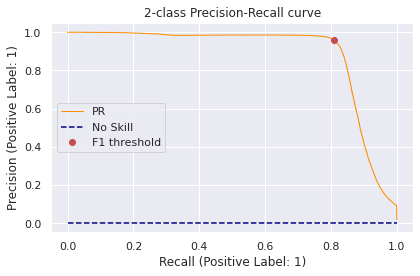

In [155]:
fig, ax = plt.subplots()
no_skill = y_test.sum().compute().values[0].get()/len(y_test)
ax.plot(recall, precision, color='darkorange', lw=1, label='PR')
ax.plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--', label='No Skill')
ax.plot(recall[np.argmax((2 * precision * recall)/ (precision + recall))],
           precision[np.argmax((2 * precision * recall)/ (precision + recall))], 'ro', label='F1 threshold')
ax.set_xlabel('Recall (Positive Label: 1)')
ax.set_ylabel('Precision (Positive Label: 1)')
ax.set_title('2-class Precision-Recall curve')
ax.legend()
plt.tight_layout()

Confusion Matrix :


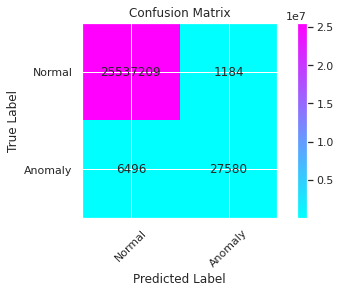

In [156]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.cool):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

In [172]:
# we can also use a custom threshold to balance out FP and FN, for example, to reduce FN (and increase FP):

threshold_idx = np.argmin(np.abs(recall-0.99))  # high recall, low precision.
print(f'Precision: {precision[threshold_idx]: 0.4f}')
print(f'Recall: {recall[threshold_idx]: 0.4f}')
pred_labels = (preds > thresholds[threshold_idx]).astype(int)

print('fraud predicted', pred_labels.sum().compute())
print('actual fraud', true_labels.sum())
# compute the auc, this should match the last test auc output above
auc = roc_auc_score(true_labels, pred_labels)
print(f'AUC {auc: 0.4f}')

print (f'Accuracy: {accuracy_score(true_labels, pred_labels): 0.4f}')

print (f'F1: {f1_score(true_labels, pred_labels): 0.4f}')



Precision:  0.1032
Recall:  0.9900
fraud predicted 326788
actual fraud 34076
AUC  0.9893
Accuracy:  0.9885
F1:  0.1870


Confusion Matrix :


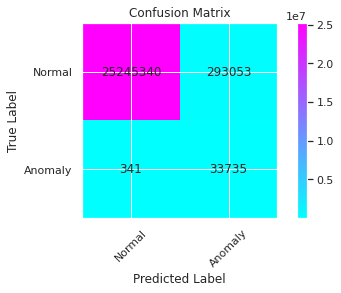

In [173]:
# and with the new threshold we see the reduced FN at cost of increased FP
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

plot_confusion_matrix(results, ['Normal','Anomaly'])

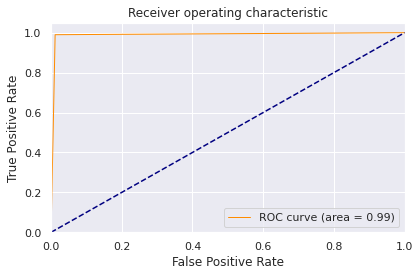

In [174]:
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")
plt.tight_layout()

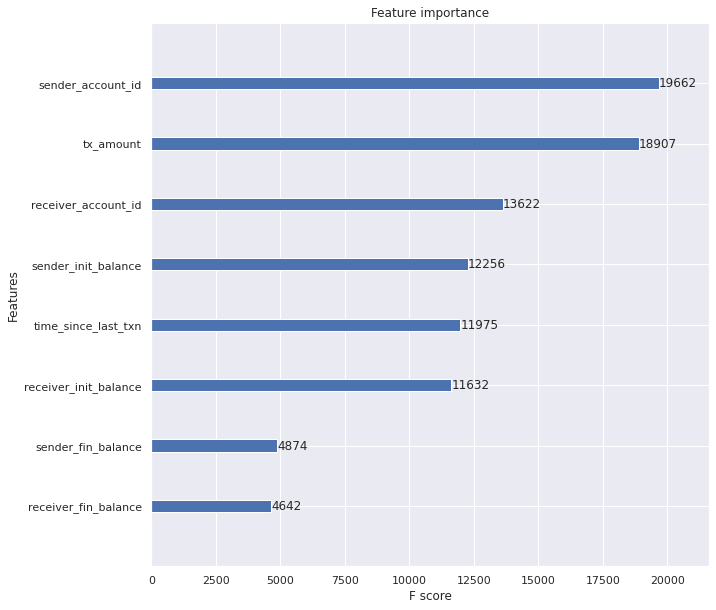

In [157]:
ax = xgb.plot_importance(model['booster'])
fig = ax.figure
fig.set_size_inches(10, 10)

## Explainability with `Shap` 

In [158]:
explainer = shap.TreeExplainer(model['booster'])
%time shap_values = explainer.shap_values(X_test.compute())

CPU times: user 12min 1s, sys: 1.82 s, total: 12min 3s
Wall time: 11min 52s


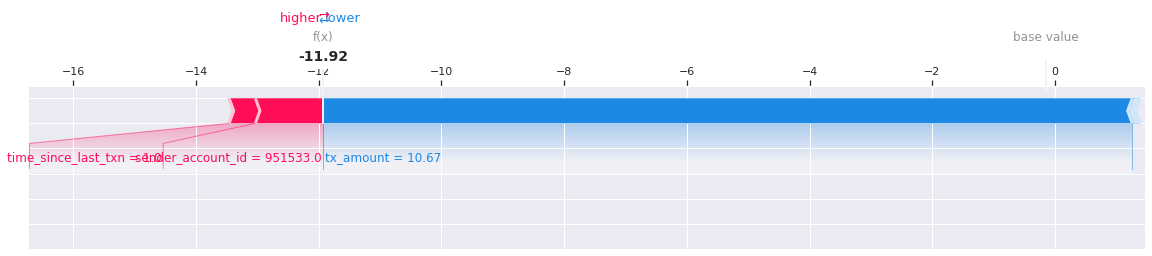

In [159]:
# visualize the first prediction's explanation
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_test.compute().loc[99131008].values.get(),
    feature_names=X_test.columns.tolist(),
    matplotlib=True
)

In [160]:
X_test.compute().loc[99131008]#.values

time_since_last_txn           1.00
tx_amount                    10.67
sender_account_id        951533.00
receiver_account_id      203175.00
sender_init_balance      193982.88
receiver_init_balance       681.92
sender_fin_balance       193972.21
receiver_fin_balance        692.59
Name: 99131008, dtype: float64

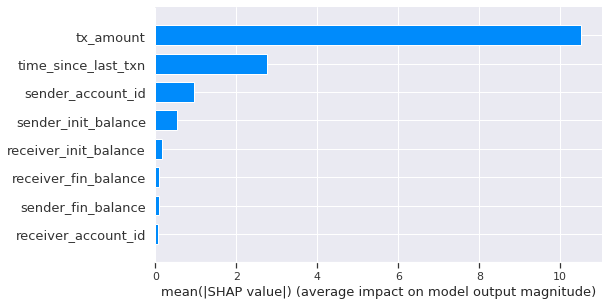

CPU times: user 1.69 s, sys: 1.84 s, total: 3.53 s
Wall time: 3.71 s


In [161]:
%time shap.summary_plot(shap_values, X_test.compute(), plot_type="bar", feature_names=X_test.columns.tolist())